<a href="https://colab.research.google.com/github/SaptarshiSen-1/Predicting-House-Price/blob/main/HousingPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving housing-prices-dataset.zip.zip to housing-prices-dataset.zip (1).zip
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
Archive:  housing-prices-dataset.zip.zip
  inflating: Housing.csv             
D

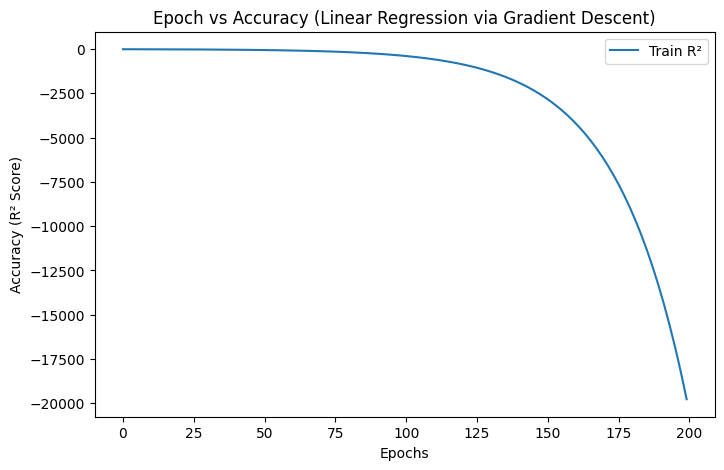

Final slope (m): -48260156.0211, intercept (c): -242315079.4433
Train R²: -19775.5358
Test R²: -12476.5189


In [2]:
# STEP 1: Install Kaggle & Set Up Credentials

!pip install kaggle -q                                  # Install the Kaggle CLI tool so we can download datasets via API

from google.colab import files                         # Import Colab's file upload helper
files.upload()                                         # Open a file picker; you MUST upload your kaggle.json (Kaggle API key)

!mkdir -p ~/.kaggle                                    # Create the hidden .kaggle directory in the current user's home (if not present)
!mv kaggle.json ~/.kaggle/                             # Move the uploaded kaggle.json file into ~/.kaggle so the CLI can find it
!chmod 600 ~/.kaggle/kaggle.json                       # Secure the credentials file (required by Kaggle CLI; owner read/write only)

# STEP 2: Download & Unzip the Dataset

!kaggle datasets download -d yasserh/housing-prices-dataset   # Use Kaggle CLI to download the dataset zip by its slug
!unzip -o housing-prices-dataset.zip                          # Unzip the downloaded archive (-o overwrites existing files if any)

# Import Python Libraries

import pandas as pd, numpy as np, matplotlib.pyplot as plt    # Data handling (pandas/numpy) and plotting (matplotlib)
from sklearn.model_selection import train_test_split          # For creating random train/test splits
from sklearn.preprocessing import StandardScaler              # For standardizing numeric features (zero mean, unit variance)
from sklearn.metrics import r2_score                          # R² metric (used here as "accuracy" for regression)

# Load & Preview the Data

data = pd.read_csv("Housing.csv")                     # Read the main CSV file from the unzipped dataset into a pandas DataFrame
print("Dataset preview:\n", data.head())              # Print the first few rows to confirm the data loaded correctly

# Select Feature & Target

X, y = data[["area"]], data["price"]                  # Choose single numeric feature 'area' as input X, and 'price' as target y

# Random Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(  # Split the full dataset into training and testing subsets
    X, y, test_size=0.2, random_state=42              # 80% train / 20% test; random_state=42 makes this split reproducible
)

# Feature Scaling

scaler = StandardScaler()                             # Create a StandardScaler instance for normalizing the 'area' feature
X_train = scaler.fit_transform(X_train)               # Fit the scaler on training X and transform it (returns a NumPy array)
X_test  = scaler.transform(X_test)                    # Apply the same scaling parameters to the test X (prevents data leakage)

# Initialize Model Parameters & Training Config

m = 0                                                 # Initialize the slope (weight) of the line y = m*x + c
c = 0                                                 # Initialize the intercept (bias) term
L, epochs = 0.01, 200                                 # Set learning rate (step size) and number of training epochs
n = len(X_train)                                      # Number of training examples (used to scale gradient magnitudes)

accuracies = []                                       # List to record R² on the training set at each epoch (our "accuracy" curve)

# Gradient Descent Training Loop

for _ in range(epochs):                               # Repeat the update steps for the desired number of epochs
    y_pred = m * X_train.flatten() + c                # Compute predictions for all training samples (vectorized)
    error  = y_pred - y_train.values                  # Compute residuals: predicted - actual prices

    #  Compute gradients of MSE loss w.r.t. m and c (closed-form for simple linear regression)
    grad_m = (-2 / n) * np.dot(X_train.flatten(), error)  # d(MSE)/dm = -2/n * Σ(x_i * error_i)
    grad_c = (-2 / n) * np.sum(error)                     # d(MSE)/dc = -2/n * Σ(error_i)

    # Parameter updates: move opposite the gradient by a step of size L (learning rate)
    m -= L * grad_m                                       # Update slope to reduce loss
    c -= L * grad_c                                       # Update intercept to reduce loss

    # Compute "accuracy" as R² on the training set for the current parameters
    r2 = r2_score(y_train, y_pred)                        # R² ranges from -inf to 1; closer to 1 is better fit
    accuracies.append(r2)                                 # Store R² so we can plot it vs. epoch

# Plot Epoch vs Accuracy (R² Only)

plt.figure(figsize=(8,5))                                # Create a new figure with a reasonable size
plt.plot(range(epochs), accuracies, label="Train R²")    # Plot R² values collected across epochs
plt.xlabel("Epochs")                                     # Label for x-axis (epoch count)
plt.ylabel("Accuracy (R² Score)")                        # Label for y-axis (we interpret R² as "accuracy" for regression)
plt.title("Epoch vs Accuracy (Linear Regression via Gradient Descent)")  # Plot title
plt.legend()                                             # Show legend so the curve is labeled
plt.show()                                               # Render the plot in the notebook output

# Final Results & Test Evaluation

print(f"Final slope (m): {m:.4f}, intercept (c): {c:.4f}")       # Print the learned line parameters after training
train_r2_final = accuracies[-1]                                  # The last recorded training R² (final epoch)
print(f"Train R²: {train_r2_final:.4f}")                         # Print final training R²

test_pred = m * X_test.flatten() + c                             # Make predictions on the (scaled) test set
print(f"Test R²: {r2_score(y_test, test_pred):.4f}")             # Compute and print R² on the held-out test data
